# Bài tập thực hành môn Phân tích và xử lý ảnh 04
# MSSV: 18110014, Họ tên: Nguyễn Phú Thành

In [1]:
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import scipy.fftpack

In [2]:
def imShows(Images, Labels = None, rows = 1, cols = 1):
    imagesArray = list(Images)
    labelsArray = [f"Image {i + 1}" for i in range(len(imagesArray))] if Labels is None else list(Labels)
    figsize = (20, 20) if ((rows == 1) and (cols == 1)) else (cols * 8, rows * 5)
    fig = plt.figure(figsize = figsize)
    for i in range(1, rows * cols + 1):
        ax = fig.add_subplot(rows, cols, i)
        image = imagesArray[i - 1]
        cmap = plt.cm.gray if (len(image.shape) < 3) else None
        ax.imshow(image, cmap = cmap)
        ax.set(title = labelsArray[i - 1], xticks = [], yticks = [])
    plt.show()
def showThreeImages(IM1, IM2, IM3):
    imShows([IM1, IM2, IM3], rows = 1, cols = 3)
def showTwoImages(IM1, IM2):
    imShows([IM1, IM2], rows = 1, cols = 2)
def showOneImage(IM1):
    imShows([IM1])
def showListImages(listImage, listLabels = None, rows = 1, cols = 1):
    imShows(listImage, Labels = listLabels, rows = rows, cols = cols)

# Bài tập 01

# Chuyển đổi thành ảnh xám

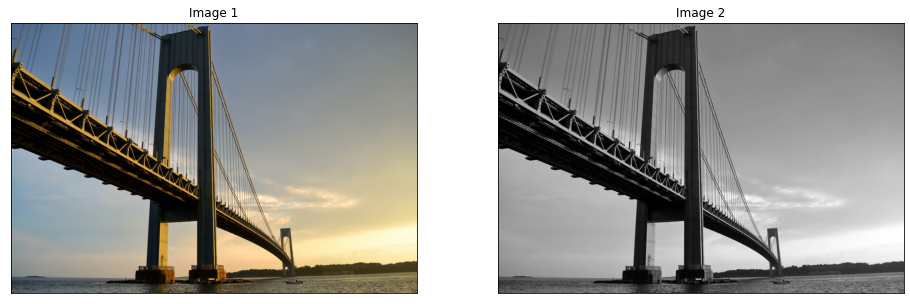

In [3]:
image_color = plt.imread('bridge.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

# Biến đổi DFT và hiển thị ảnh ở miền tần số

In [4]:
def convertToDFT(img2D):
    img_float32 = np.float32(img2D)
    
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnum_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    
    return magnum_spectrum, dft_shift

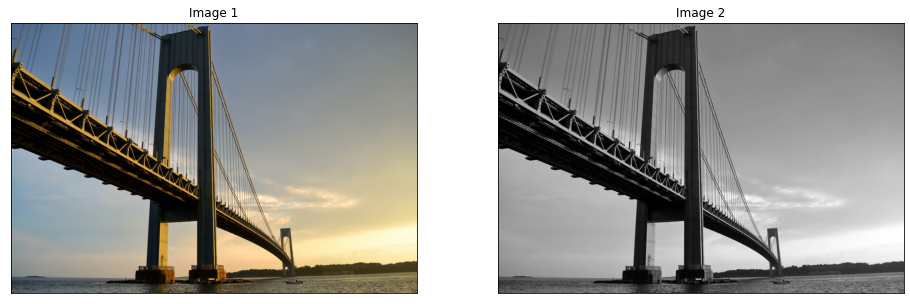

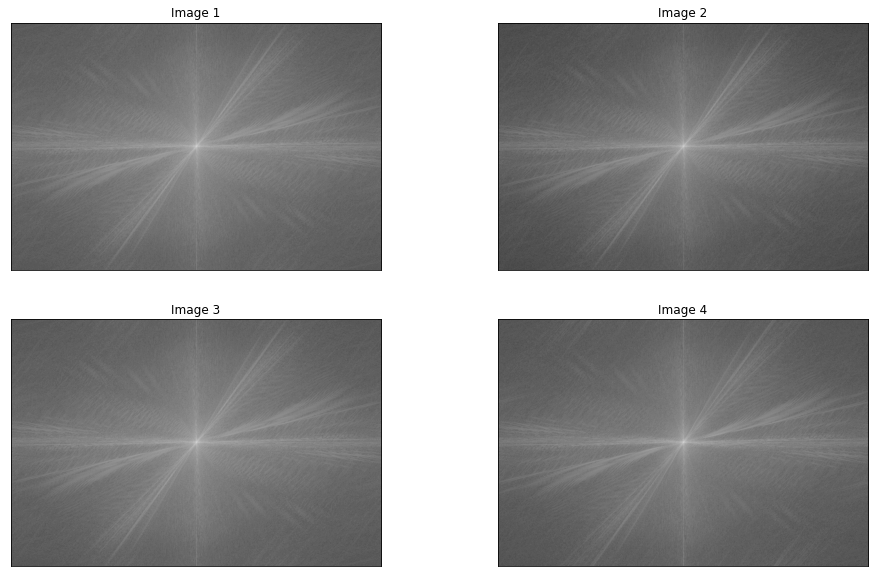

In [5]:
images = []

image_dft_frequency, dft_shift = convertToDFT(image_gray)
images.append(image_dft_frequency)
for channel in range(3):
    image_dft_frequency, _ = convertToDFT(image_color[:,:,channel])
    images.append(image_dft_frequency)
showTwoImages(image_color, image_gray)
showListImages(images, rows = 2, cols = 2)

# Thực hiện tạo ảnh mask để bỏ miền tần số cao và hiển thị ảnh texture

In [6]:
def inverseDFT(mask, dft_shift):
    fshift =  dft_shift* mask
    f_ishift = np.fft.ifftshift(fshift)
    img_inverse = cv2.idft(f_ishift)
    return cv2.magnitude(img_inverse[:,:,0], img_inverse[:,:,1])

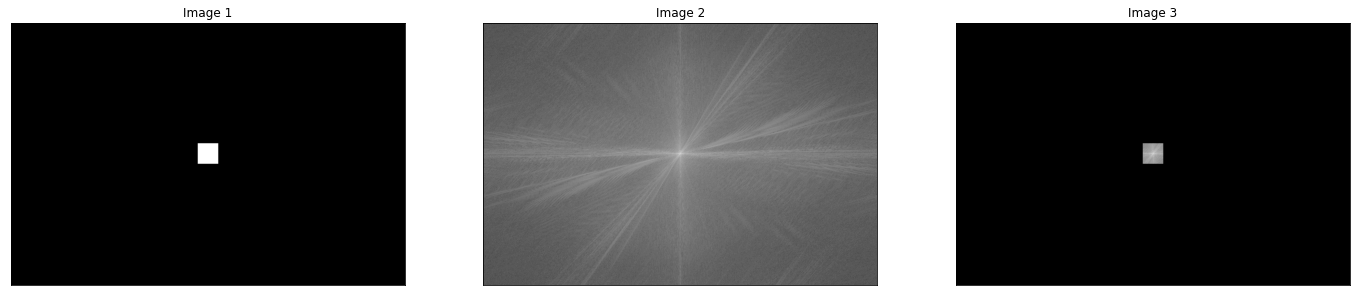

In [7]:
rows, cols = image_gray.shape
crop_rows, crop_cols = rows//2, cols//2

mask = np.zeros((rows, cols, 2), dtype = np.uint8)
crop_size = 50

mask[(crop_rows - crop_size) : (crop_rows + crop_size), (crop_cols - crop_size) : (crop_cols + crop_size)] = 1

image_dft_frequency_crop = image_dft_frequency * mask[:,:,0]

showListImages([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], rows = 1, cols = 3)

In [8]:
image_inverse = inverseDFT(mask, dft_shift)

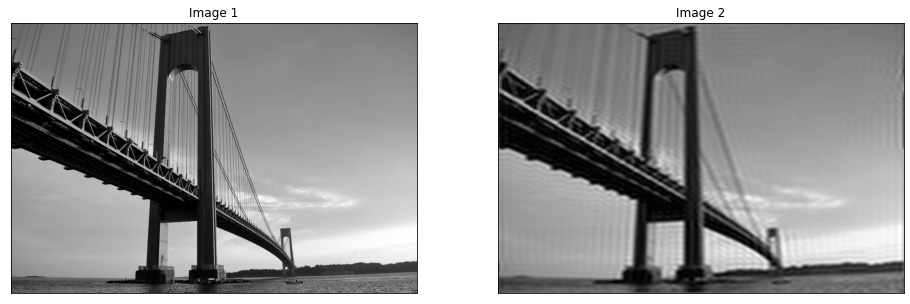

In [9]:
showTwoImages(image_gray, image_inverse)

# Thực hiện tạo ảnh mask để bỏ miền tần số thấp và hiển thị ảnh edge

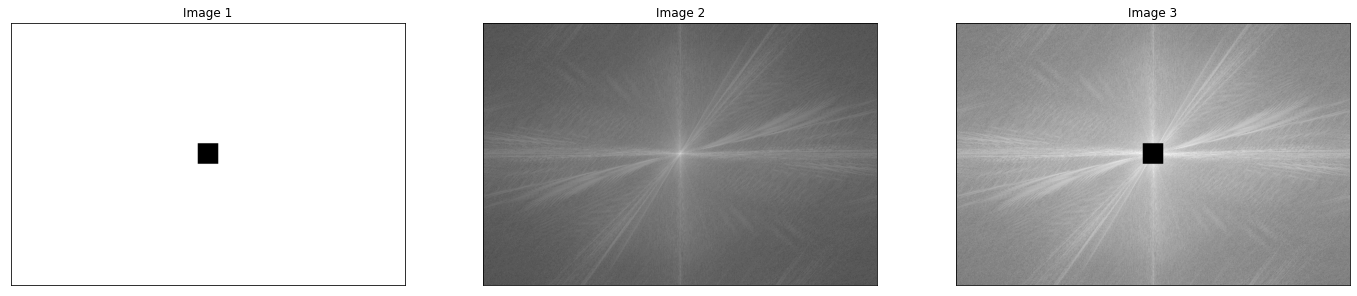

In [10]:
rows, cols = image_gray.shape
crop_rows, crop_cols = rows//2, cols//2

mask = np.ones((rows, cols, 2), dtype = np.uint8)
crop_size = 50

mask[(crop_rows - crop_size) : (crop_rows + crop_size), (crop_cols - crop_size) : (crop_cols + crop_size)] = 0

image_dft_frequency_crop = image_dft_frequency * mask[:,:,0]

showListImages([mask[:,:,0], image_dft_frequency, image_dft_frequency_crop], rows = 1, cols = 3)

In [11]:
image_inverse = inverseDFT(mask, dft_shift)

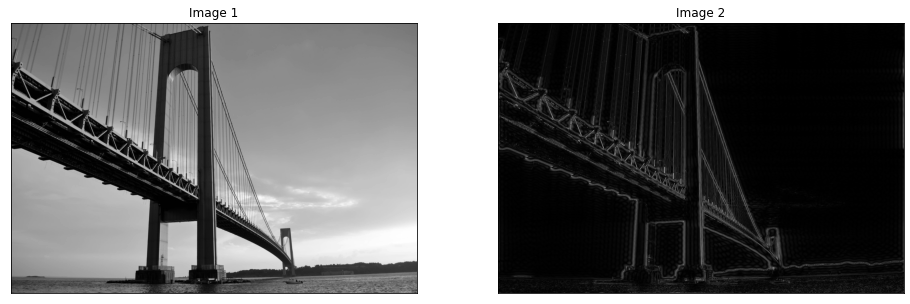

In [12]:
showTwoImages(image_gray, image_inverse)

# Bài tập 02

# Kiếm một ảnh trên internet và thực hiện các bước sau:

# * Chuyển đổi thành ảnh xám

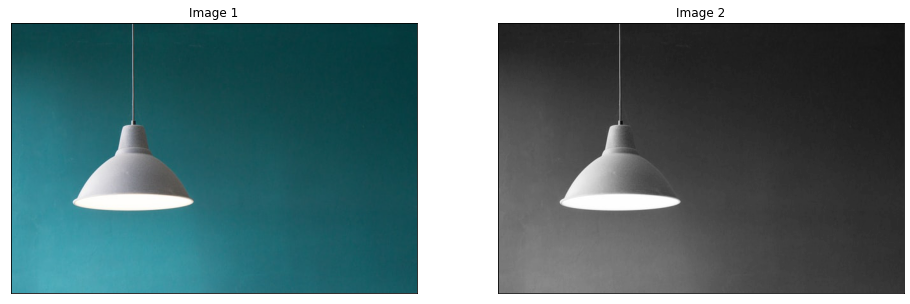

In [13]:
image_color = plt.imread('lamp.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
showTwoImages(image_color, image_gray)

# * Biến đổi DCT và hiển thị ảnh DCT

In [14]:
def convertToDCT(arr):
    return scipy.fftpack.dct(scipy.fftpack.dct(arr, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho')

In [15]:
def InvertDCT(arr):
    return scipy.fftpack.idct(scipy.fftpack.idct(arr, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho')

In [16]:
dct_result = np.zeros_like(image_gray)
im_size = image_gray.shape

for i in np.r_[:im_size[0] : 8]:
    for j in np.r_[:im_size[1] : 8]:
        dct_result[i : (i + 8), j : (j + 8)] = convertToDCT(image_gray[i : (i + 8), j : (j + 8)])

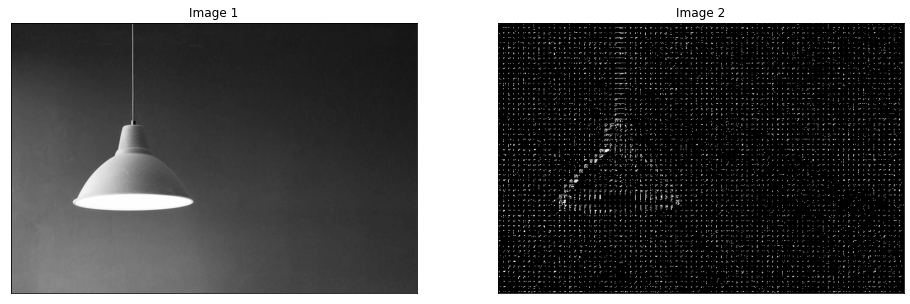

In [17]:
showTwoImages(image_gray, dct_result)

# * Đặt ngưỡng giữ lại khoảng 5% hệ số DCT và hiển thị ảnh nén kết quả

In [18]:
def compressDCT(img, threshold = 0.01):
    dct_result = np.zeros_like(img, dtype = 'float')
    im_dct = np.zeros_like(img, dtype = 'float')
    im_size = img.shape

    for i in np.r_[:im_size[0] : 8]:
        for j in np.r_[:im_size[1] : 8]:
            dct_result[i : (i + 8), j : (j + 8)] = convertToDCT(img[i : (i + 8), j : (j + 8)])
    
    dct_thresh = dct_result * (abs(dct_result) > (threshold * np.max(dct_result)))
    
    for i in np.r_[:im_size[0] : 8]:
        for j in np.r_[:im_size[1] : 8]:
            im_dct[i : (i + 8), j : (j + 8)] = InvertDCT(dct_thresh[i : (i + 8), j : (j + 8)])
    return im_dct, dct_thresh

Keep only 5.012807377049181% of DCT coefficents


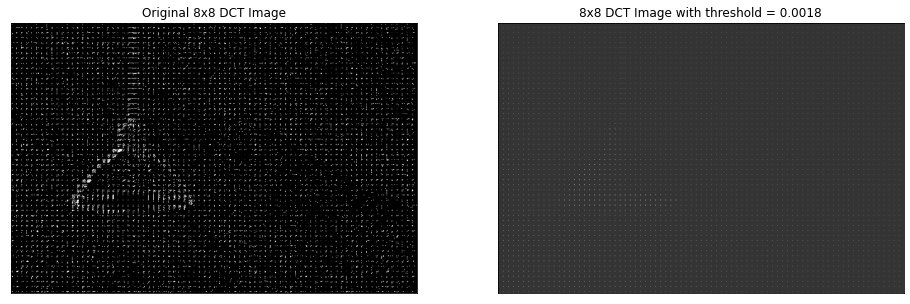

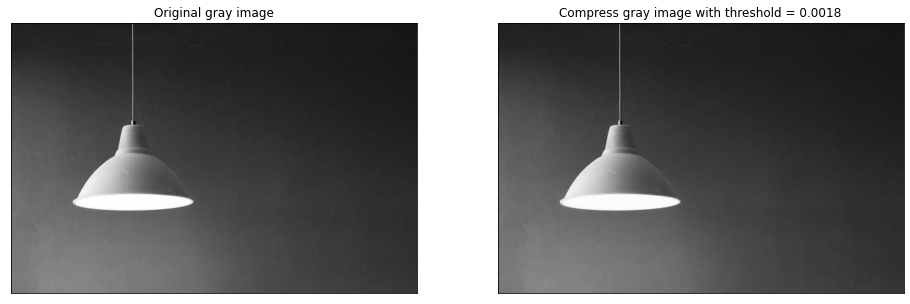

In [19]:
thresh = 0.0018
im_dct, dct_thresh = compressDCT(image_gray, thresh)

percentNonZeros = np.sum(dct_thresh != 0)/(image_gray.size * 1.0)
print(f'Keep only {percentNonZeros * 100}% of DCT coefficents')

showListImages([dct_result, dct_thresh],\
               ['Original 8x8 DCT Image', f'8x8 DCT Image with threshold = {thresh}'],
               rows = 1, cols = 2)

showListImages([image_gray, im_dct],\
               ['Original gray image', f'Compress gray image with threshold = {thresh}'],
               rows = 1, cols = 2)

# 3. Kiếm một ảnh màu trên internet và thực hiện nén các ảnh này dùng DFT và DCT bằng cách giữ lại 5% hệ số.
# Sau đó khôi phục lại ảnh màu và lưu xuống thư mục cũng như xuất dung lượng ảnh xem giảm được bao nhiêu dung lượng

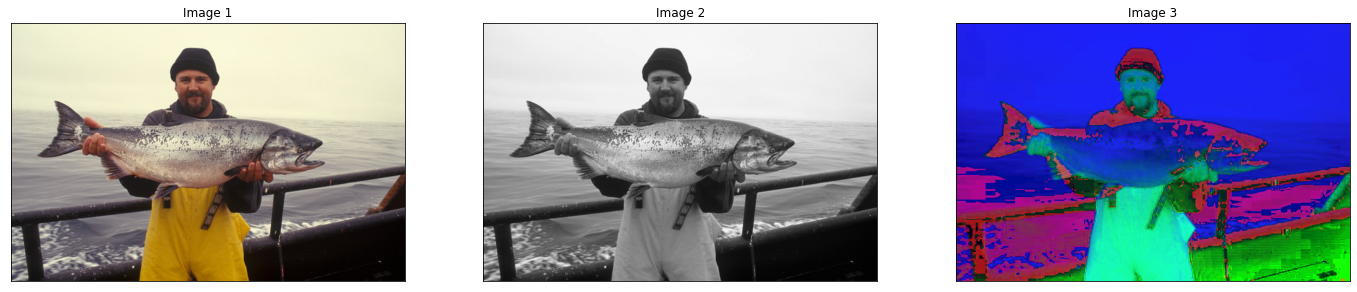

In [20]:
image_color = plt.imread('fisherman.jpg')
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_color, cv2.COLOR_RGB2HSV)
showThreeImages(image_color, image_gray, image_hsv)

In [21]:
def compressDFT(img, threshold = 0.01):
    dft_result = np.zeros_like(img, dtype = 'complex')
    im_dft = np.zeros_like(img, dtype = 'complex')
    im_shape = img.shape

    for i in np.r_[:im_shape[0]:8]:
        for j in np.r_[:im_shape[1]:8]:
            dft_result[i : (i + 8), j : (j + 8)] = np.fft.fft2(img[i : (i + 8), j : (j + 8)])
            
    dft_thresh = dft_result * (abs(dft_result) > threshold * np.max(abs(dft_result)))
    for i in np.r_[:im_shape[0] : 8]:
        for j in np.r_[:im_shape[1]:8]:
            im_dft[i : (i + 8), j : (j + 8)] = np.fft.ifft2(dft_thresh[i : (i + 8), j : (j + 8)])
    return im_dft, dft_thresh

Keep only 4.999627976190476% of DFT coefficents in H channel
Keep only 5.001116071428571% of DFT coefficents in S channel
Keep only 5.001116071428571% of DFT coefficents in V channel


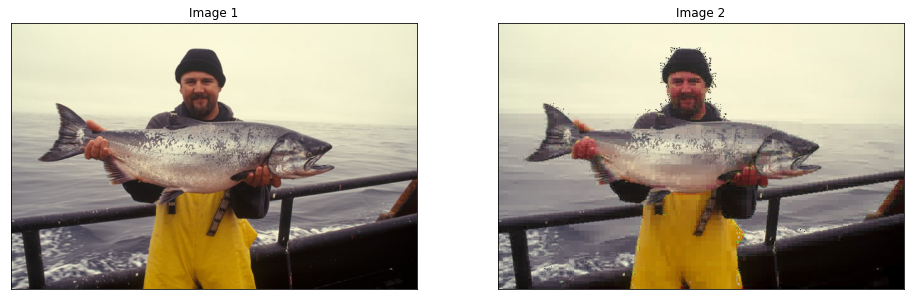

Size of original image (in bytes) =  42890
Size of compressed image using DFT (in bytes) =  23296
Differences in size (in bytes) =  19594


In [22]:
result = image_hsv.copy()

# Using bisection method to find these thresholds
thresChannel = [0.04400634765625, 0.01139068603515625, 0.01805877685546875]

for channel, name in enumerate(['H','S', 'V']):
    dft_hsv, dft_thresh_hsv = compressDFT(image_hsv[:,:,channel], threshold = thresChannel[channel])
    percentNonZeros = np.sum(dft_thresh_hsv != 0)/(image_hsv[:,:,channel].size * 1.0)
    print(f'Keep only {percentNonZeros * 100}% of DFT coefficents in {name} channel')

    result[:,:,channel] = abs(dft_hsv).astype(np.uint8)

result = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)
showTwoImages(image_color, result)

Image.fromarray(result, 'RGB').save('fisherman_dft.jpg')
original_size = os.path.getsize('fisherman.jpg')
compressed_size = os.path.getsize('fisherman_dft.jpg')

print('Size of original image (in bytes) = ', original_size)
print('Size of compressed image using DFT (in bytes) = ', compressed_size)
print('Differences in size (in bytes) = ', original_size - compressed_size)

Keep only 5.0% of DCT coefficents in H channel
Keep only 4.997395833333333% of DCT coefficents in S channel
Keep only 4.994047619047619% of DCT coefficents in V channel


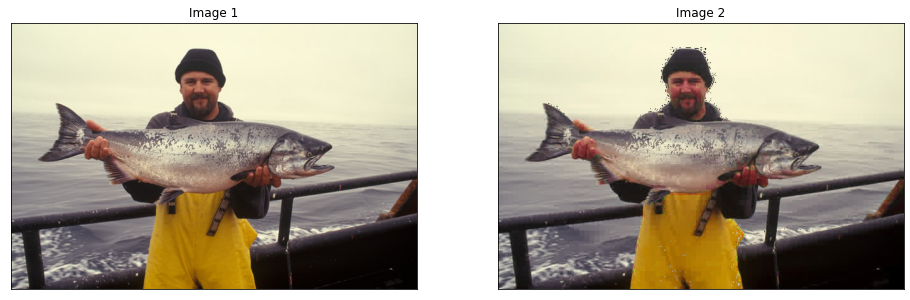

Size of original image (in bytes) =  42890
Size of compressed image, using DCT (in bytes) =  23670
Differences in size (in bytes) =  19220


In [23]:
result = image_hsv.copy()

# Using numerical method to find these thresholds
thresChannel = [0.04058837890625, 0.00855255126953125, 0.01476287841796875]

for channel, name in enumerate(['H','S', 'V']):
    dct_hsv, dct_thresh_hsv = compressDCT(image_hsv[:,:,channel], threshold = thresChannel[channel])
    percentNonZeros = np.sum(dct_thresh_hsv != 0)/(image_hsv[:,:,channel].size * 1.0)
    print(f'Keep only {percentNonZeros * 100}% of DCT coefficents in {name} channel')

    result[:,:,channel] = abs(dct_hsv).astype(np.uint8)

result = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)
showTwoImages(image_color, result)

Image.fromarray(result, 'RGB').save('fisherman_dct.jpg')

original_size = os.path.getsize('fisherman.jpg')
compressed_size = os.path.getsize('fisherman_dct.jpg')

print('Size of original image (in bytes) = ', original_size)
print('Size of compressed image, using DCT (in bytes) = ', compressed_size)
print('Differences in size (in bytes) = ', original_size - compressed_size)